<a href="https://colab.research.google.com/github/andersonvilla/introduccion-ia-2023/blob/main/01_Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# CARGUE DE DATOS

En esta primera parte se requiere subir la llave de Kaggle, un archivo .json para ejecutar las siguientes líneas y así tener disponible los datos en nuestro Collab, (A Tener en cuenta que es una competencia, por lo cual para disponibilizar los datos se requiere su inscripción en la misma) Adicionalmente, validar que el archivo json sea leído correctamente, en caso de que no, volver a ejecutar esta celda!!

In [186]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"andersonvillasierra1","key":"99ee4a7c981ce7f7d80625ac3ca47602"}'}

Se descarga el data set directamente del repositorio de Kaggle y lo disponibilizamos en nuestro ambiente.

In [187]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c playground-series-s3e20
! unzip playground-series-s3e20.zip -d playground-series-s3e20

playground-series-s3e20.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s3e20.zip
replace playground-series-s3e20/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: playground-series-s3e20/sample_submission.csv  
replace playground-series-s3e20/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: playground-series-s3e20/test.csv  
replace playground-series-s3e20/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: playground-series-s3e20/train.csv  


# Exploración del dataset

Leemos ambos archivos, los datos de entrenamiento tanto como los de prueba

In [188]:
%matplotlib inline
d = pd.read_csv("playground-series-s3e20/train.csv")
d.head()
t = pd.read_csv("playground-series-s3e20/test.csv")
t.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [189]:
k = d.isna().sum()
k[k!=0]

SulphurDioxide_SO2_column_number_density          14609
SulphurDioxide_SO2_column_number_density_amf      14609
SulphurDioxide_SO2_slant_column_number_density    14609
SulphurDioxide_cloud_fraction                     14609
SulphurDioxide_sensor_azimuth_angle               14609
                                                  ...  
Cloud_surface_albedo                                484
Cloud_sensor_azimuth_angle                          484
Cloud_sensor_zenith_angle                           484
Cloud_solar_azimuth_angle                           484
Cloud_solar_zenith_angle                            484
Length: 70, dtype: int64

In [190]:
d.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [191]:
ccols = [i for i in d.columns if not i in d._get_numeric_data()]
print (ccols)

['ID_LAT_LON_YEAR_WEEK']


In [192]:
for c in ccols:
    print ("%10s"%c, np.unique(d[c].dropna()))

ID_LAT_LON_YEAR_WEEK ['ID_-0.510_29.290_2019_00' 'ID_-0.510_29.290_2019_01'
 'ID_-0.510_29.290_2019_02' ... 'ID_-3.299_30.301_2021_50'
 'ID_-3.299_30.301_2021_51' 'ID_-3.299_30.301_2021_52']


Se imprime el porcentaje de valores faltantes en cada columna

In [193]:
(d.isnull().sum() * 100/d.shape[0]).sort_values(ascending = False)

UvAerosolLayerHeight_aerosol_height          99.444466
UvAerosolLayerHeight_solar_zenith_angle      99.444466
UvAerosolLayerHeight_solar_azimuth_angle     99.444466
UvAerosolLayerHeight_sensor_azimuth_angle    99.444466
UvAerosolLayerHeight_aerosol_pressure        99.444466
                                               ...    
latitude                                      0.000000
week_no                                       0.000000
year                                          0.000000
longitude                                     0.000000
emission                                      0.000000
Length: 76, dtype: float64

# Preprocesado de datos
Se planean dos estrategias de limpieza, una donde eliminaremos las columnas con un porcetanje de 99.4% de datos faltantes y rellenando los datos faltantes con la media de los datos. Y la segunda es donde eliminaremos las columnas por este mismo criterio, pero en esta ocasión se eliminaran las filas con datos faltantes

Ya que se identifica, que hay columnas con un valor de 99.4%, lo cuál representa un alto porcentaje de datos faltantes, tomamos la decisión de eliminar dichas columnas, como primer proceso de limpieza

In [194]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

Gráfica de datos faltantes

<Axes: >

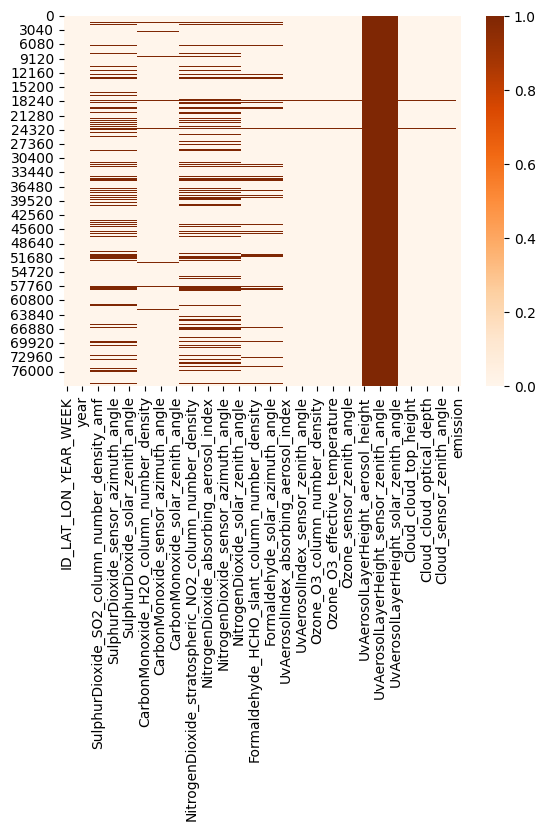

In [195]:
sns.heatmap(d.isna(),cmap='Oranges')

In [196]:
newData = d.drop(d.columns[57:64], axis=1)

# Estrategia 1: Llenar datos faltante con la media de los datos.

Aqui, el siguiente proceso para limpieza de datos, se llenan los datos vacios con la media de los datos

In [197]:
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

In [198]:
df_clean = imp_median.fit_transform(newData.iloc[:, 1:-1])

In [199]:
df_impute = pd.DataFrame(data = df_clean, columns = newData.columns[1:-1])

Quedamos con un dataframe que no cuenta con las columnas con un porcentaje de 99.4% de datos vacíos y remplazando los datos faltantes con la media, siendo este el dataframe df_impute

In [200]:
df_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 67 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  float64
 3   week_no                                                   79023 non-null  float64
 4   SulphurDioxide_SO2_column_number_density                  79023 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              79023 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            79023 non-null  float64
 7   SulphurDioxide_cloud_fraction                             79023 non-null  float64
 8   SulphurDioxide_s

Se hace la asignación con los datos procesados en dos variables, X, y Y, donde X es el dataFrame que contiene las características con los valores faltantes imputados. y Y contiene la columna emission del dataFrame sin las columnas previamente eliminadas. Y contiene la columna emission que representa la variable objetivo o la que el modelo a implementar intentará predecir.

In [201]:
X = df_impute
Y = newData['emission']

# Estrategia 2: Eliminación de filas con datos vacíos

A continuación creamos una segunda versión del dataframe en la cual eliminamos las filas que contienen datos vacios, dado que eran más de 20.000 filas con datos faltantes queriamos comprobar cual de las dos versiones tenía mejores resultados

In [202]:
df_row_clean = newData.dropna(0)

<ipython-input-202-eadcebbeafcb>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df_row_clean = newData.dropna(0)


In [203]:
df_row_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57209 entries, 1 to 79022
Data columns (total 69 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      57209 non-null  object 
 1   latitude                                                  57209 non-null  float64
 2   longitude                                                 57209 non-null  float64
 3   year                                                      57209 non-null  int64  
 4   week_no                                                   57209 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  57209 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              57209 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            57209 non-null  float64
 8   SulphurDioxide_c

Se hace la asignación de la segunda versión del dataframe a X_RC, analogo a X

In [204]:
X_RC = df_row_clean.drop(['ID_LAT_LON_YEAR_WEEK', 'emission'], axis = 1).fillna(0)

In [205]:
X_RC

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
1,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779
2,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,55923.790554,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296
4,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,59904.314844,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612
5,-0.510,29.290,2019,5,0.000294,0.871713,0.000242,0.227656,-13.453690,57.097124,...,43494.921743,5530.354546,49846.001010,4495.301362,7.556143,0.250228,30.128401,37.007020,-137.388719,21.157820
6,-0.510,29.290,2019,6,-0.000285,0.791956,-0.000226,0.119397,72.198647,58.496368,...,53483.783984,4378.614648,58804.276563,3537.050659,10.493107,0.240828,4.585368,30.491541,-128.196338,21.721202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79017,-3.299,30.301,2021,47,-0.000257,0.668691,-0.000172,0.257957,71.891731,65.816658,...,47198.775641,6894.667968,53218.918203,5894.667968,25.124038,0.308299,24.648991,38.736509,-129.933645,29.499534
79018,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,54703.511452,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214
79019,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,53983.493958,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469
79021,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,...,41395.313100,7896.456885,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868


In [206]:
Y_RC = df_row_clean['emission']

In [207]:
Y_RC

1         4.025176
2         4.231381
4         4.347317
5         4.310819
6         4.269334
           ...    
79017    30.297634
79018    29.404171
79019    29.186497
79021    28.125792
79022    27.239302
Name: emission, Length: 57209, dtype: float64

# Modelos


Ahora contamos con dos datasets con los cuales estamos interesados en hacer pruebas y ver cómo responden distintos modelos con ellos, el primer dataset es aquel donde en los datos faltantes se llenaron con la media de los datos, y las variables correspondientes a este dataset son (X,Y)  donde X contiene las características y Y contiene la variable a predecir. El segundo dataset, aquel que cuyas filas que tenían datos faltantes se deciden eliminar, y las variables correspondientes a este dataset con (X_RC, Y_RC) donde representan lo anterior descrito pero ya con este segundo dataset.

# Modelos supervisados


Random Forest  - Dataset 1. (Datos faltantes con media de datos)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=45)

In [211]:
clf = RandomForestRegressor(random_state = 45, n_jobs=-1)

In [212]:
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=45)

In [213]:
y_pred = clf.predict(X_test)

In [214]:
RMSE_random_f = mean_squared_error(y_test, y_pred, squared=False)
r2_random_f = r2_score(y_test, y_pred)
MAE_random_f = mean_absolute_error(y_test,y_pred)
print(f'RMSE Score: {RMSE_random_f}')
print("R^2 : ",r2_random_f )
print("MAE :", MAE_random_f)


RMSE Score: 22.535370367758908
R^2 :  0.9747592356050864
MAE : 8.773575390916621


LGBMRegressor - Dataset 1. (Datos faltantes con media de datos)

In [215]:
XLGBM_train, XLGBM_test, YLGBM_train, YLGBM_test = train_test_split(X, Y, test_size=0.3, random_state=45)


In [216]:
lgbm_model = LGBMRegressor(random_state=45)

In [217]:
lgbm_model.fit(XLGBM_train, YLGBM_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16629
[LightGBM] [Info] Number of data points in the train set: 55316, number of used features: 67
[LightGBM] [Info] Start training from score 81.860552


LGBMRegressor(random_state=45)

In [218]:
YLGBM_pred = lgbm_model.predict(XLGBM_test)

In [219]:
RMSE_lgbm = mean_squared_error(YLGBM_test, YLGBM_pred, squared=False)
r2_lgbm = r2_score(YLGBM_test, YLGBM_pred)
MAE_lgbm = mean_absolute_error(YLGBM_test,YLGBM_pred)

print(f'RMSE Score: {RMSE_lgbm}')
print("R^2 : ", r2_lgbm)
print("MAE :", MAE_lgbm)

RMSE Score: 29.936194991650158
R^2 :  0.9554583500190286
MAE : 19.632414345534347


XGBC - Dataset 2.(Filas con datos faltantes eliminadas)

In [220]:
X_RC_train, X_RC_test, Y_RC_train, Y_RC_test = train_test_split(X_RC, Y_RC, test_size = 0.3, random_state = 42)


In [221]:
xgb = XGBRegressor()

In [222]:
xgb.fit(X_RC_train, Y_RC_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [223]:
y_rc_pred = xgb.predict(X_RC_test)

In [224]:
RMSE_xgbc = mean_squared_error(Y_RC_test, y_rc_pred, squared=False)
r2_xgbc = r2_score(Y_RC_test, y_rc_pred)
MAE_xgbc = mean_absolute_error(Y_RC_test,y_rc_pred)

print(f'RMSE Score: {RMSE_xgbc}')
print("R^2 : ", r2_xgbc)
print("MAE :", MAE_xgbc)

RMSE Score: 25.709075973684286
R^2 :  0.9657398312435168
MAE : 13.879364612260398


CatBoostRegressor - Dataset 2. (Filas con datos faltantes eliminadas)

In [225]:
!pip install catboost

In [226]:
from catboost import CatBoostRegressor

XCATBOOST_train, XCATBOOST_test, YCATBOOST_train, YCATBOOST_test = train_test_split(X_RC, Y_RC, test_size=0.3, random_state=45)


In [227]:
catboost_model = CatBoostRegressor(random_state=45)


In [228]:
catboost_model.fit(XCATBOOST_train, YCATBOOST_train)


Learning rate set to 0.073347
0:	learn: 131.1655707	total: 82.2ms	remaining: 1m 22s
1:	learn: 127.5302722	total: 129ms	remaining: 1m 4s
2:	learn: 123.7601992	total: 167ms	remaining: 55.4s
3:	learn: 121.5390182	total: 274ms	remaining: 1m 8s
4:	learn: 120.1889082	total: 333ms	remaining: 1m 6s
5:	learn: 117.2447433	total: 392ms	remaining: 1m 4s
6:	learn: 114.3260228	total: 455ms	remaining: 1m 4s
7:	learn: 112.0433876	total: 511ms	remaining: 1m 3s
8:	learn: 111.1615721	total: 593ms	remaining: 1m 5s
9:	learn: 109.0327285	total: 664ms	remaining: 1m 5s
10:	learn: 108.0391809	total: 768ms	remaining: 1m 9s
11:	learn: 107.1969362	total: 816ms	remaining: 1m 7s
12:	learn: 105.3913099	total: 887ms	remaining: 1m 7s
13:	learn: 104.6562710	total: 952ms	remaining: 1m 7s
14:	learn: 103.6462531	total: 1.03s	remaining: 1m 7s
15:	learn: 101.8757031	total: 1.08s	remaining: 1m 6s
16:	learn: 100.4934527	total: 1.13s	remaining: 1m 5s
17:	learn: 98.3440769	total: 1.18s	remaining: 1m 4s
18:	learn: 96.9440195	tot

In [229]:
YCATBOOST_pred = catboost_model.predict(XCATBOOST_test)


In [230]:
RMSE_cat_boost = mean_squared_error(YCATBOOST_test, YCATBOOST_pred, squared=False)
r2_cat_boost = r2_score(YCATBOOST_test, YCATBOOST_pred)
MAE_cat_boost = mean_absolute_error(YCATBOOST_test,YCATBOOST_pred)

print(f'RMSE Score: {RMSE_cat_boost}')
print("R^2 : ", r2_cat_boost)
print("MAE :", MAE_cat_boost)

RMSE Score: 27.09344455326553
R^2 :  0.9650920410511953
MAE : 16.610861247799356


In [231]:
def create_results_table(model_names, rmse_values, r2_values, mae_values):
    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame({
        'Modelo': model_names,
        'RMSE': rmse_values,
        'R^2': r2_values,
        'MAE': mae_values
    })

    print(results_df)

In [232]:
model_names = ['Random Forest', 'LightGBM', 'XGBC', 'CatBoost']
rmse_values = [RMSE_random_f, RMSE_lgbm, RMSE_xgbc, RMSE_cat_boost]
r2_values = [r2_random_f, r2_lgbm,r2_xgbc, r2_cat_boost]
mae_values = [MAE_random_f, MAE_lgbm, MAE_xgbc, MAE_cat_boost]

create_results_table(model_names, rmse_values, r2_values, mae_values)

          Modelo       RMSE       R^2        MAE
0  Random Forest  22.535370  0.974759   8.773575
1       LightGBM  29.936195  0.955458  19.632414
2           XGBC  25.709076  0.965740  13.879365
3       CatBoost  27.093445  0.965092  16.610861


# Modelos no supervisados (PCA)


Para trabajar con PCA, se decide crear una copia del dataset original, para trabajar sobre ella, donde sacaremos la variable objetivo en "emission" y eliminaremos columnas irrelevantes

In [233]:
data_pca = d
data_pca_cl = data_pca.drop(data_pca.columns[57:64], axis=1)

df_clean_pca = imp_median.fit_transform(data_pca_cl.iloc[:, 1:-1])

df_impute_clean = pd.DataFrame(data = df_clean_pca, columns = data_pca_cl.columns[1:-1])

emission = data_pca_cl[["emission"]]

Se define el método para escalar los datos, con el fin de preparar los datos para ser alimentados en PCA

Se ajusta y se transforman los datos

In [234]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df_impute_clean)

Se define el PCA, aún sin especificar la cantidad de componentes

Se ajusta y se transforman los datos

In [235]:
pca = PCA(n_components=None)

pca_train = pca.fit_transform(scaled_data)

In [236]:
scaled_data.shape

(79023, 67)

Se define el "cross validation score" para encontrar el parámetro más óptimo

In [237]:
scores = cross_val_score(pca, scaled_data, emission, cv=5)

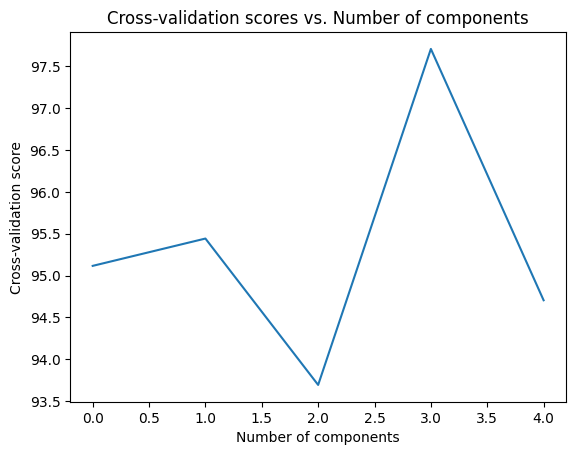

In [239]:
plt.plot(range(0, len(scores)), scores)
plt.xlabel('Number of components')
plt.ylabel('Cross-validation score')
plt.title('Cross-validation scores vs. Number of components')
plt.show()

La gráfica indica que el componente optimo sería 3, así que se re define PCA pero con el número de componentes

Se ajusta y se transforman los datos

In [240]:
pca_optimal = PCA(n_components=3)

pca_train_optimal  = pca_optimal.fit_transform(scaled_data)

In [241]:
pca_train_optimal.shape


(79023, 3)

Se define un nuevo dataframe de entrenamiento apartir de lo obtenido anteriormente con las transformaciones


In [242]:
train_PCA = pd.DataFrame({"feature1":pca_train_optimal[:,0],"feature2":pca_train_optimal[:,1],"emission":emission["emission"]})

In [243]:
X = train_PCA.drop("emission",axis = 1)

y = train_PCA.emission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 45)

RANDOM FOREST - PCA

In [244]:
clf = RandomForestRegressor(random_state = 45, n_jobs=-1)

clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=45)

In [245]:
pred_PCA = clf.predict(X_test)

In [246]:
rmse_pca_rf = mean_squared_error(y_test, pred_PCA, squared=False)
r2_pca_rf = r2_score(y_test, pred_PCA)
mae_pca_rf = mean_absolute_error(y_test,pred_PCA)

print(f'RMSE Score: {rmse_pca_rf}')
print("R^2 : ", r2_pca_rf)
print("MAE :", mae_pca_rf)

RMSE Score: 152.47788146210883
R^2 :  -0.1555448365451002
MAE : 79.8458303438251


LIGHTGBM - PCA

In [247]:
lgbm_model = LGBMRegressor(random_state=45)

lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 55316, number of used features: 2
[LightGBM] [Info] Start training from score 81.860552


LGBMRegressor(random_state=45)

In [248]:
pred_PCA = lgbm_model.predict(X_test)

In [249]:
rmse_pca_lgbm = mean_squared_error(y_test, pred_PCA, squared=False)
r2_pca_lgbm = r2_score(y_test, pred_PCA)
mae_pca_lgbm = mean_absolute_error(y_test,pred_PCA)

print(f'RMSE Score: {rmse_pca_lgbm}')
print("R^2 : ", r2_pca_lgbm)
print("MAE :", mae_pca_lgbm)

RMSE Score: 142.47260931650794
R^2 :  -0.008871513322353142
MAE : 73.4738724289038


XGBC - PCA

In [250]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [251]:
pred_PCA = xgb.predict(X_test)

In [252]:
rmse_pca_xgbc = mean_squared_error(y_test, pred_PCA, squared=False)
r2_pca_xgbc = r2_score(y_test, pred_PCA)
mae_pca_xgbc = mean_absolute_error(y_test,pred_PCA)

print(f'RMSE Score: {rmse_pca_xgbc}')
print("R^2 : ", r2_pca_xgbc)
print("MAE :", mae_pca_xgbc)

RMSE Score: 147.86898090119394
R^2 :  -0.08674402827529182
MAE : 75.04928554701694


CATBOOST - PCA


In [253]:
catboost_model = CatBoostRegressor(random_state=45)

catboost_model.fit(X_train, y_train)

Learning rate set to 0.077188
0:	learn: 145.3134847	total: 9.35ms	remaining: 9.34s
1:	learn: 145.2920742	total: 16ms	remaining: 7.98s
2:	learn: 145.2704605	total: 22.8ms	remaining: 7.59s
3:	learn: 145.2512124	total: 29.8ms	remaining: 7.43s
4:	learn: 145.2361044	total: 40.2ms	remaining: 8.01s
5:	learn: 145.2267316	total: 47.1ms	remaining: 7.8s
6:	learn: 145.2114488	total: 54.2ms	remaining: 7.68s
7:	learn: 145.1994314	total: 61.5ms	remaining: 7.63s
8:	learn: 145.1882169	total: 68.3ms	remaining: 7.52s
9:	learn: 145.1781442	total: 76ms	remaining: 7.52s
10:	learn: 145.1609435	total: 83.6ms	remaining: 7.51s
11:	learn: 145.1545696	total: 90.4ms	remaining: 7.44s
12:	learn: 145.1432487	total: 97.4ms	remaining: 7.39s
13:	learn: 145.1327578	total: 104ms	remaining: 7.35s
14:	learn: 145.1228983	total: 112ms	remaining: 7.38s
15:	learn: 145.1168266	total: 119ms	remaining: 7.33s
16:	learn: 145.1093290	total: 126ms	remaining: 7.29s
17:	learn: 145.0980444	total: 133ms	remaining: 7.26s
18:	learn: 145.093

In [255]:
rmse_pca_cb = mean_squared_error(y_test, pred_PCA, squared=False)
r2_pca_cb = r2_score(y_test, pred_PCA)
mae_pca_cb = mean_absolute_error(y_test,pred_PCA)

print(f'RMSE Score: {rmse_pca_cb}')
print("R^2 : ", r2_pca_cb)
print("MAE :", mae_pca_cb)

RMSE Score: 147.86898090119394
R^2 :  -0.08674402827529182
MAE : 75.04928554701694


In [256]:
model_names = ['Random Forest PCA', 'LightGBM PCA', 'XGBC PCA', 'CatBoost PCA']
rmse_values = [rmse_pca_rf, rmse_pca_lgbm, rmse_pca_xgbc, rmse_pca_cb]
r2_values = [r2_pca_rf, r2_pca_lgbm,r2_pca_xgbc, r2_pca_cb]
mae_values = [mae_pca_rf, mae_pca_lgbm, mae_pca_xgbc, mae_pca_cb]

create_results_table(model_names, rmse_values, r2_values, mae_values)

              Modelo        RMSE       R^2        MAE
0  Random Forest PCA  152.477881 -0.155545  79.845830
1       LightGBM PCA  142.472609 -0.008872  73.473872
2           XGBC PCA  147.868981 -0.086744  75.049286
3       CatBoost PCA  147.868981 -0.086744  75.049286
